In [1]:
startDate   =  "1995-10-01"
endDate     =  "2024-09-30"
model_months=  [6 ,7,8]
model_site  = [
    "13311450"  
              ]
idv         = [ "00060_Mean" ,"tmean" ,"Days_Since_October_1st" ]

In [2]:
df_cleaned_csv = "df_cleaned.csv" 
model_df_site_csv ="model_df_site.csv"
sorted_df_csv= "sorted_df.csv"
sorted_df_var_csv ="sorted_df_var.csv"

In [3]:
fontsize = 15


linewidth=4

xlab = ''#'Date'

ylab = 'Stream Temperature (°C)'

title = "High-Elevation Small Streams (USGS 13311450)"

fig_name = 'test_pred_OBS.png'



In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dataretrieval import nwis
from statsmodels.tsa.stattools import acf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from datetime import date
today = date.today()
print(today)

2025-05-07


In [5]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'dec_lat_va', 'dec_long_va', 'drain_area_va' 
                   ,   'alt_va'
                  ]
filtered_df = site_info_df[columns_to_save]
parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate) 


dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year
dailyStreamtemp_df = dailyStreamtemp_df[ dailyStreamtemp_df['Month'].isin( model_months  )    ]
print( dailyStreamtemp_df.head() )

                     datetime   site_no  00010_Maximum 00010_Maximum_cd  \
258 2012-06-01 00:00:00+00:00  13311450            9.1                A   
259 2012-06-02 00:00:00+00:00  13311450            8.1                A   
260 2012-06-03 00:00:00+00:00  13311450            7.0                A   
261 2012-06-04 00:00:00+00:00  13311450            8.5                A   
262 2012-06-05 00:00:00+00:00  13311450            5.5                A   

     00010_Minimum 00010_Minimum_cd  00010_Mean 00010_Mean_cd  00060_Mean  \
258            4.1                A         6.0             A        85.1   
259            4.5                A         5.7             A       108.0   
260            4.3                A         5.4             A       119.0   
261            4.2                A         5.8             A       124.0   
262            3.3                A         4.1             A       142.0   

    00060_Mean_cd        Date  Month  Year  
258             A  2012-06-01      6  201

In [6]:
print( "type(dailyStreamtemp)",type(dailyStreamtemp) )
print( "dailyStreamtemp[0]", dailyStreamtemp[0] )
print(  "dailyStreamtemp[1]", dailyStreamtemp[1] )
print( "type(dailyStreamtemp[0])",  type(dailyStreamtemp[0]))
print(  "type(dailyStreamtemp[1])",  type(dailyStreamtemp[1]) )

type(dailyStreamtemp) <class 'tuple'>
dailyStreamtemp[0]                             site_no  00010_Maximum 00010_Maximum_cd  \
datetime                                                              
2011-09-17 00:00:00+00:00  13311450            NaN              NaN   
2011-09-18 00:00:00+00:00  13311450            NaN              NaN   
2011-09-19 00:00:00+00:00  13311450            NaN              NaN   
2011-09-20 00:00:00+00:00  13311450            NaN              NaN   
2011-09-21 00:00:00+00:00  13311450            NaN              NaN   
...                             ...            ...              ...   
2024-09-26 00:00:00+00:00  13311450           10.0                A   
2024-09-27 00:00:00+00:00  13311450            9.5                A   
2024-09-28 00:00:00+00:00  13311450            9.7                A   
2024-09-29 00:00:00+00:00  13311450            9.5                A   
2024-09-30 00:00:00+00:00  13311450            6.8                A   

                   

In [7]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)

prism_df['date'] = pd.to_datetime( prism_df['date']) 
def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days   
    return days_difference if days_difference >= 0 else days_difference + 365
prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)

# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)


prism_df['Date'] = prism_df['date'].dt.date

In [8]:
prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d", "Days_Since_October_1st" ]]
dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',  
  '00010_Mean', '00060_Mean', 
       'Month', 'Year' ]]
result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')
#print(result)

#print(result.columns)

# Count the number of NaN values in each column
na_count = result.isna().sum()
# Print the result
print(na_count)
# Drop rows with any NaN values
df_cleaned = result.dropna()
# Print the cleaned DataFrame
print(df_cleaned.head())
# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()
# Print the result
print(na_count )

tmean                      0
site_no                    0
Date                       0
rad_d                      0
Days_Since_October_1st     0
00010_Mean                98
00060_Mean                 0
Month                      0
Year                       0
dtype: int64
       tmean   site_no        Date     rad_d  Days_Since_October_1st  \
0  11.892000  13311450  2012-06-01  4.183052                     243   
1  10.656000  13311450  2012-06-02  4.200266                     244   
2  11.382001  13311450  2012-06-03  4.217481                     245   
3  13.261001  13311450  2012-06-04  4.234695                     246   
4   2.307000  13311450  2012-06-05  4.251909                     247   

   00010_Mean  00060_Mean  Month  Year  
0         6.0        85.1      6  2012  
1         5.7       108.0      6  2012  
2         5.4       119.0      6  2012  
3         5.8       124.0      6  2012  
4         4.1       142.0      6  2012  
tmean                     0
site_no            

In [9]:
var = pd.DataFrame()  # Initialize an empty DataFrame outside the loop

evaluate_df = pd.DataFrame( )

bias_q = pd.DataFrame( )

df_site_pred_test_0 = pd.DataFrame( ) 

In [10]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    #errors = abs(predictions - test_labels)
    r2 = r2_score(test_labels, predictions)
    #print(f'R-squared: {r2}')

    # Compute McFadden's pseudo R-squared
    #ll_model = model.llf  # Log-likelihood of the fitted model
    #ll_null = model.llnull  # Log-likelihood of the null model
   # pseudo_r2 = 1 - (ll_model / ll_null)
    #Adjusted R-squared, on the other hand, adjusts the R-squared value based on the number of predictors in the model. 

    # Number of samples and predictors
    n = test_features.shape[0]  # Number of test samples
    p = test_features.shape[1]  # Number of predictors

# Compute Adjusted R-squared
    pseudo_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    
    #pseudo_r2 = model.oob_score_

    mse = mean_squared_error(test_labels, predictions)

    bias = np.mean( predictions- test_labels)

    #print("Mean Error (Bias):", bias)
    
    rmse = np.sqrt(mse)
    RSS = np.sum(( test_labels  -  predictions) ** 2)
    TSS = np.sum(( test_labels  - np.mean( test_labels )) ** 2)
    NSE = 1 - (RSS / TSS)
    #print(f"Mean Squared Error: {mse}")
    #print(f"Root Mean Squared Error: {rmse}")

    # standard deviation ratio
    std_ratio = np.std(predictions) / np.std(test_labels)
    # correlation
    
    correlation = np.corrcoef(predictions, test_labels)[0, 1]
    
    return r2,pseudo_r2,mse,bias,rmse,NSE,std_ratio,correlation

In [11]:
params = {
    "n_estimators":   100 , #default
    
    'criterion': 'absolute_error',
    "max_depth":None,
    "random_state": 42
    , 'oob_score': True
}

param_grid = {
    #'bootstrap': [True],
    'max_depth': [5 ,10,  20, None ],
    #'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100,200 ]
    , "random_state": [42],

    'criterion': ['absolute_error']
    , 'oob_score': [True]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf
                           , param_grid = param_grid 
                         # ,cv = 3, n_jobs = -1, verbose = 2
                          )

In [12]:
for site in model_site:
    merged_df_wy=df_cleaned[df_cleaned['site_no']==site ]
    num_rows = merged_df_wy.shape[0]

    autocorr_values = acf( merged_df_wy['00010_Mean'], nlags= 5)  # Compute autocorrelation up to lag 10
    
    q_mean = merged_df_wy['00060_Mean'].mean()
    q_std = merged_df_wy['00060_Mean'].std()
    
    cv_q = q_std / q_mean

    grouped_stats_yr = merged_df_wy.groupby('Year')['00060_Mean'].agg( mean='mean' )
    inter_cv_q =   grouped_stats_yr['mean'].std() /  grouped_stats_yr['mean'].mean()

    grouped_stats_yr_st = merged_df_wy.groupby('Year')['00010_Mean'].agg( mean='mean' )
    inter_cv_st =   grouped_stats_yr_st['mean'].std() /  grouped_stats_yr_st['mean'].mean()

    var0 = pd.DataFrame({
    'site': [site],
    'std_dev_st': [ np.std( merged_df_wy['00010_Mean']) ],
    'cv_q': [  cv_q ],
        'inter_cv_q':[ inter_cv_q ],
        'inter_cv_st':[ inter_cv_st ],
    'range': [ np.max( merged_df_wy['00010_Mean']) - np.min( merged_df_wy['00010_Mean']) ],
    'autocorr_t_1': [ autocorr_values[1]],
    'autocorr_t_2': [ autocorr_values[2]]
    })
    
    var=pd.concat( [var0,var] )
    
    input=  merged_df_wy[  idv]
    
    if num_rows <90:
        print("stop:", site)
    else: 
        print( merged_df_wy['Date'].head() )

        # 1. random split
        #X_train, X_test, y_train, y_test = train_test_split( input,  merged_df_wy['00010_Mean'], test_size=0.2, random_state=42)
        # 2. early train, late test
        

        # Sort the DataFrame by date to ensure chronological order
        merged_df_wy = merged_df_wy.sort_values(by='Date').reset_index(drop=True)

        # Determine the split point for 80% of the data
        train_size = int(0.8 * len( merged_df_wy ))

        # Split the DataFrame into training and testing sets
        train_df =  merged_df_wy.iloc[:train_size].copy()
        test_df =  merged_df_wy.iloc[train_size:].copy()
        X_train=train_df[idv]


        X_test=test_df[idv]


        y_test=test_df[ "00010_Mean"]


        y_train=train_df[ "00010_Mean"]
        
        # Initialize the RandomForestRegressor model
        rf_model = RandomForestRegressor(**params)
        # Fit the model
        rf_model.fit(X_train, y_train)
        # Predict on the test set
        
        
        grid_search.fit( X_train, y_train )
        grid_search.best_params_
        best_grid = grid_search.best_estimator_

        
        grid_r2, grid_pseudo_r2, grid_mse, grid_bias,grid_rmse, grid_NSE , grid_std_ratio, grid_correlation= evaluate(best_grid, X_test, y_test )
        base_r2, base_pseudo_r2, base_mse, base_bias,base_rmse, base_NSE, base_std_ratio, base_correlation = evaluate( rf_model, X_test, y_test )
        evaluate_data = {
            "site": [  site ] ,
            "number_of_obs": [ num_rows ] ,
            'base_r2': [base_r2],
            'grid_r2': [grid_r2],

            
            'base_pseudo_r2': [base_pseudo_r2],
            'grid_pseudo_r2': [grid_pseudo_r2],
            
            'base_mse': [base_mse],
            'grid_mse': [grid_mse],
            'base_bias': [base_bias],
            'grid_bias': [grid_bias],
            'base_rmse': [base_rmse],
            'grid_rmse':[grid_rmse],
            'base_NSE': [  base_NSE],
            'grid_NSE':[ grid_NSE ],
           "base_std_ratio" : [base_std_ratio],
            
            "grid_std_ratio": [ grid_std_ratio ],
            "base_correlation":[ base_correlation ],
            "grid_correlation" : [ grid_correlation ]
        }
        evaluate_df0 = pd.DataFrame(evaluate_data)
        evaluate_df = pd.concat( [ evaluate_df , evaluate_df0 ] )

        y_pred_best = best_grid.predict(X_test)
        df_q = pd.DataFrame({
        "y_test": y_test,
        "y_pred_best": y_pred_best
        })
        quantiles = pd.qcut( y_test , q=4 , labels=["Q1", "Q2", "Q3", "Q4"])
        df_q['quantile'] = quantiles
        obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
        df_q['bias']=   df_q['y_pred_best'] - df_q['y_test']
        error_by_quantile = df_q.groupby('quantile')['bias'].mean()
        bias_q0=pd.DataFrame({
        "site": [site],  # Make sure it's a list so it can be added as a row
        
        "Q1_obs": [obs_by_quantile[0]],
        "Q2_obs": [obs_by_quantile[1]],
        "Q3_obs": [obs_by_quantile[2]],
        "Q4_obs": [obs_by_quantile[3]],
        
        "Q1_bias": [error_by_quantile[0]],
        "Q2_bias": [error_by_quantile[1]],
        "Q3_bias": [error_by_quantile[2]],
        "Q4_bias": [error_by_quantile[3]]
        })
        bias_q=pd.concat([bias_q,bias_q0])

        df_site_pred_test = pd.DataFrame({
            'site': site,

            
            "y_test": y_test,
        "y_pred_best": y_pred_best
        })
        df_site_pred_test_0=pd.concat([ df_site_pred_test, df_site_pred_test_0])

0    2012-06-01
1    2012-06-02
2    2012-06-03
3    2012-06-04
4    2012-06-05
Name: Date, dtype: object


/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_3257/427806178.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_by_quantile = df_q.groupby('quantile')['y_test'].mean()
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_3257/427806178.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_quantile = df_q.groupby('quantile')['bias'].mean()
/var/folders/_4/klhstfsn73nfrxlfr8_r9dhc0000gn/T/ipykernel_3257/427806178.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

In [13]:
site_pred_test = df_site_pred_test_0[ df_site_pred_test_0['y_test']>0 ]

# Merge the two DataFrames by index, keeping all rows (even with NA)
merged_df = pd.concat([df_cleaned, site_pred_test], axis=1)
merged_df

,tmean,site_no,Date,rad_d,Days_Since_October_1st,00010_Mean,00060_Mean,Month,Year,site,y_test,y_pred_best
0,11.892000,13311450,2012-06-01,4.183052,243,6.0,85.10,6,2012,NaN,NaN,NaN
1,10.656000,13311450,2012-06-02,4.200266,244,5.7,108.00,6,2012,NaN,NaN,NaN
2,11.382001,13311450,2012-06-03,4.217481,245,5.4,119.00,6,2012,NaN,NaN,NaN
3,13.261001,13311450,2012-06-04,4.234695,246,5.8,124.00,6,2012,NaN,NaN,NaN
4,2.307000,13311450,2012-06-05,4.251909,247,4.1,142.00,6,2012,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1191,11.974700,13311450,2024-08-27,5.680688,330,8.8,9.77,8,2024,NaN,NaN,NaN
1192,7.881100,13311450,2024-08-28,5.697902,331,8.3,9.61,8,2024,NaN,NaN,NaN
1193,10.701050,13311450,2024-08-29,5.715116,332,7.7,9.56,8,2024,NaN,NaN,NaN
1194,13.306649,13311450,2024-08-30,5.732331,333,8.3,9.36,8,2024,NaN,NaN,NaN


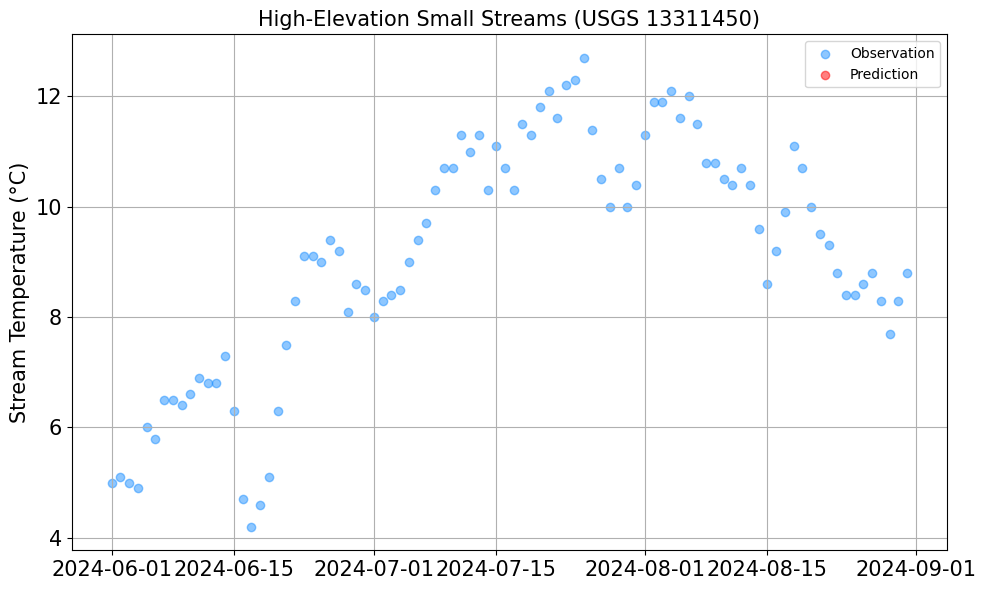

In [14]:
plt.figure(figsize=(10, 6))

df = merged_df[ merged_df['Year'] == 2024    ] 

plt.scatter(df['Date'], df['00010_Mean'], color='dodgerblue', label='Observation', alpha=0.5)

plt.scatter(df['Date'], df['y_pred_best'], color='red', label='Prediction', alpha=0.5)

plt.xlabel( xlab , fontsize = fontsize)
plt.ylabel( ylab , fontsize = fontsize )
plt.title(  title , fontsize = fontsize)
plt.xticks( fontsize = fontsize )
plt.yticks( fontsize = fontsize )
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig( fig_name )

plt.show()

In [15]:



site_pred_test = df_site_pred_test_0[ df_site_pred_test_0['y_test']>0 ]

# Merge the two DataFrames by index, keeping all rows (even with NA)
merged_df2 = pd.concat([ test_df, site_pred_test], axis=1)
merged_df2


,tmean,site_no,Date,rad_d,Days_Since_October_1st,00010_Mean,00060_Mean,Month,Year,site,y_test,y_pred_best
878,18.475599,13311450,2022-07-27,5.147048,299,11.0,22.60,7,2022,13311450,11.0,10.21550
879,19.756800,13311450,2022-07-28,5.164262,300,11.6,22.10,7,2022,13311450,11.6,10.27500
880,19.528000,13311450,2022-07-29,5.181476,301,11.3,21.80,7,2022,13311450,11.3,10.49875
881,19.132200,13311450,2022-07-30,5.198690,302,11.3,21.10,7,2022,13311450,11.3,10.57125
882,20.160000,13311450,2022-07-31,5.215905,303,11.1,20.60,7,2022,13311450,11.1,10.89625
...,...,...,...,...,...,...,...,...,...,...,...,...
1093,11.974700,13311450,2024-08-27,5.680688,330,8.8,9.77,8,2024,13311450,8.8,8.78500
1094,7.881100,13311450,2024-08-28,5.697902,331,8.3,9.61,8,2024,13311450,8.3,8.55725
1095,10.701050,13311450,2024-08-29,5.715116,332,7.7,9.56,8,2024,13311450,7.7,8.79800
1096,13.306649,13311450,2024-08-30,5.732331,333,8.3,9.36,8,2024,13311450,8.3,8.73475


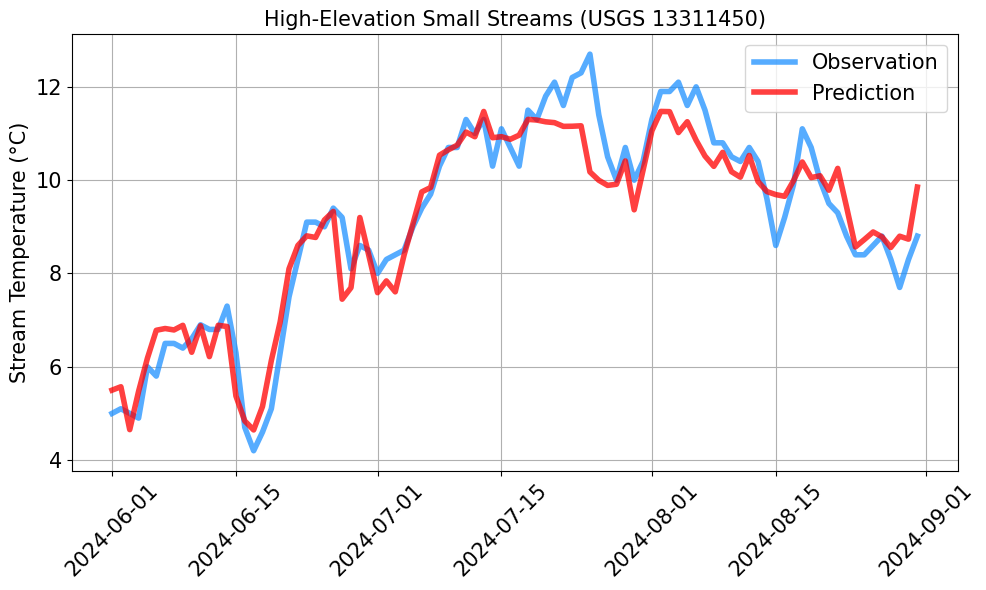

In [16]:
plt.figure(figsize=(10, 6))

df = merged_df2[ merged_df2['Year'] == 2024    ] 

plt.plot(df['Date'], df['00010_Mean'], color='dodgerblue', label='Observation', alpha=0.75, linewidth = linewidth)

plt.plot(df['Date'], df['y_pred_best'], color='red', label='Prediction', alpha=0.75, linewidth = linewidth )

plt.xlabel( xlab , fontsize = fontsize)
plt.ylabel( ylab , fontsize = fontsize )
plt.title(  title , fontsize = fontsize)
plt.xticks( fontsize = fontsize )

plt.tick_params("x", rotation=45)

plt.yticks( fontsize = fontsize )
plt.legend( fontsize = fontsize )
plt.grid(True)
plt.tight_layout()

plt.savefig( fig_name )

plt.show()